# Cardiomegaly Detection from Chest X-rays Using CNN – A Deep Learning Approach

## 📁 Dataset Source & Context
To address the lack of a dedicated **Cardiomegaly X-ray dataset**, I utilized a **Kaggle-hosted version** of the **NIH ChestX-ray14 dataset**, one of the largest publicly available chest X-ray datasets. The dataset I worked with was already filtered to focus on **Cardiomegaly classification**. It provided two categories:

- ***True (images labeled with Cardiomegaly)***

- ***False (images without Cardiomegaly)***

All images were resized to **128×128**, later resized to **224×224** for model input. They were also preprocessed using **CLAHE (Contrast Limited Adaptive Histogram Equalization)** to enhance image clarity. The dataset was balanced with a **1:1 train-test split** to ensure equal representation of both classes.

## 🧪 Medical Insight: Cardiothoracic Ratio (CTR)
The dataset is clinically relevant because Cardiomegaly is often evaluated using the **Cardiothoracic Ratio (CTR)** from **chest X-rays**:

**CTR = MRD + MLD / ID**
​
 
Where:

- **MRD = Midline to Right Heart Diameter**

- **MLD = Midline to Left Heart Diameter**

- **ID = Internal Chest Diameter**

**CTR ≥ 0.5** is considered indicative of Cardiomegaly. While this project focused on image classification, it lays the groundwork for **automated CTR-based** severity estimation in future iterations.

#### **Import the libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Activation, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

#### **Import the dataset from Drive**

In [3]:
import os
import pandas as pd

def load_image_paths_labels(base_dir):
    data = []
    for label_dir in ['true', 'false']:
        label = 1 if label_dir == 'true' else 0
        folder_path = os.path.join(base_dir, label_dir)
        
        if not os.path.exists(folder_path):
            print(f"❌ Directory not found: {folder_path}")
            continue
        
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(folder_path, fname)
                data.append((filepath, label))
    
    return pd.DataFrame(data, columns=['filepath', 'label'])

# ✅ Replace this with your full dataset paths
train_path = r'train\train'
test_path  = r'test\test'

# Load data
train_df = load_image_paths_labels(train_path)
test_df  = load_image_paths_labels(test_path)

*Checking the Dataset Values*

In [4]:
train_df.head()

,filepath,label
0,train\train\true\1.png,1
1,train\train\true\10.png,1
2,train\train\true\100.png,1
3,train\train\true\1000.png,1
4,train\train\true\1001.png,1


In [5]:
test_df.head()

,filepath,label
0,test\test\true\1.png,1
1,test\test\true\10.png,1
2,test\test\true\100.png,1
3,test\test\true\101.png,1
4,test\test\true\102.png,1


## 🛠️ Data Preprocessing & Pipeline
- Loaded and labeled images from separate **true/ and false/** directories

- Resized images to **224×224** and normalized pixel values to **[0, 1]**

- Converted labels to **one-hot encoded** vectors for categorical **cross-entropy loss**

- Performed data augmentation on the training set **(rotation, zoom, shift, flip)**

- Created efficient TensorFlow **ImageDataGenerator pipelines for training, validation, and testing**

#### **Convert and Show the Images into RGB format**

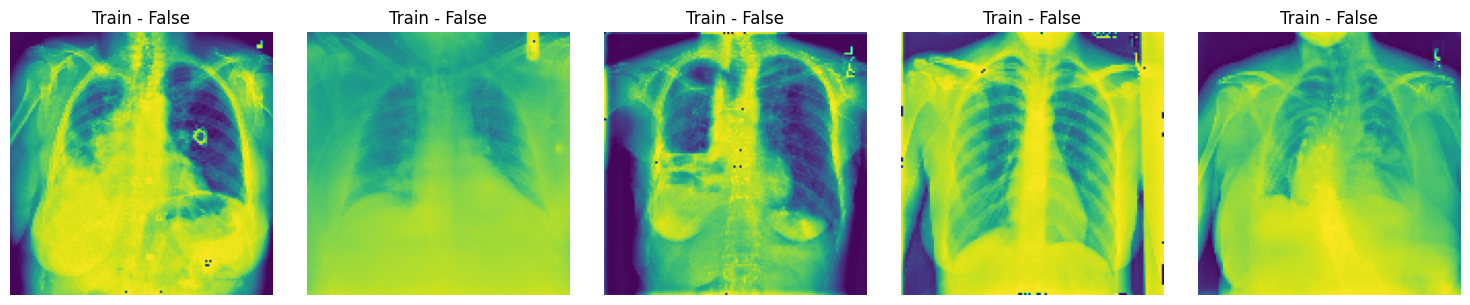

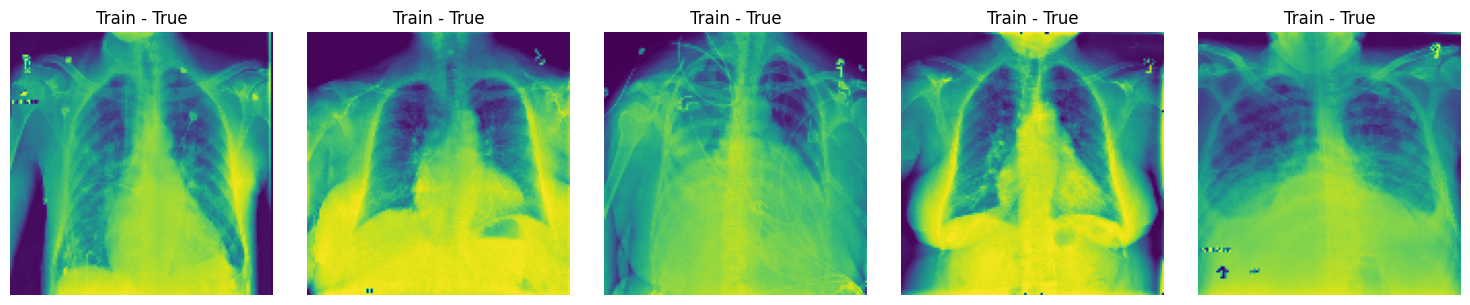

In [6]:
# Function to display N sample images for each class
def show_sample_images(df, label, n=5, title=''):
    sample_df = df[df['label'] == label].sample(n)
    
    plt.figure(figsize=(15, 3))
    for i, row in enumerate(sample_df.itertuples()):
        img = Image.open(row.filepath)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{title} - {'True' if row.label == 1 else 'False'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 5 sample images labeled as 'False' (label=0)
show_sample_images(train_df, label=0, n=5, title='Train')

# Show 5 sample images labeled as 'True' (label=1)
show_sample_images(train_df, label=1, n=5, title='Train')


#### **Load the Images Dataset, check Pixels numbers and Format**

In [7]:
# Set target image size (must be same as used in training, e.g. 224x224)
img_height, img_width = 224, 224

def images_to_array(df):
    images = []
    labels = []
    for row in tqdm(df.itertuples(), total=len(df)):
        try:
            img = Image.open(row.filepath).convert('RGB')  # force 3 channels
            img = img.resize((img_width, img_height))
            img_array = np.array(img) / 255.0  # normalize pixels to 0-1
            images.append(img_array)
            labels.append(row.label)
        except Exception as e:
            print(f"Error loading image {row.filepath}: {e}")
    return np.array(images), np.array(labels)

# Convert training images
X_train, y_train = images_to_array(train_df)

# Convert test images
X_test, y_test = images_to_array(test_df)

# Check shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


100%|██████████| 1114/1114 [00:08<00:00, 125.31it/s]


X_train shape: (4438, 224, 224, 3)
y_train shape: (4438,)
X_test shape: (1114, 224, 224, 3)
y_test shape: (1114,)


#### *Shape of Images with Pixels Range*

In [8]:
# Denormalize the first image
denormalized_img = (X_train[0] * 255).astype('uint8')

# Check shape and type
print("Shape:", denormalized_img.shape)
print("Pixel range:", denormalized_img.min(), "to", denormalized_img.max())


Shape: (224, 224, 3)
Pixel range: 0 to 255


#### **Train and Test the Dataset using Splitting Method**

In [9]:
# Train-validation split from X_train
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# One-hot encode
y_train_cat = to_categorical(y_train, num_classes=2)
y_valid_cat = to_categorical(y_valid, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

## 🧱 CNN Architecture
The deep learning model was built using TensorFlow and Keras, with the following architecture:

- **3 Convolutional blocks with ReLU activation and Batch Normalization**

- **MaxPooling layers** after each conv block

- **Fully Connected Dense layer with Dropout for regularization**

- **Output layer: Softmax activation with 2 units for binary classification**

- **Optimizer: Adamax (LR = 0.0005)**

- **Loss Function: Categorical Crossentropy**

- **Epochs: 15**

- **Batch Size: 32**

#### **Applying the Image Data Generator with training Values**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32, shuffle=True)
valid_generator = val_test_datagen.flow(X_valid, y_valid_cat, batch_size=32, shuffle=False)
test_generator  = val_test_datagen.flow(X_test,  y_test_cat,  batch_size=32, shuffle=False)


#### **Applying the Convolutional Neural Networks(CNN's) Algorithm**

In [11]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\anast\AppData\Local\miniconda3\envs\df_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,272,386 (199.40 MB)

 Trainable params: 52,271,106 (199.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

#### **Applying the Epochs to Train the CNN's Model**

In [12]:
Epochs = 15

history = model.fit(x = train_generator, epochs = Epochs, verbose = 1, 
                   validation_data = valid_generator, validation_steps = None, shuffle = False)

c:\Users\anast\AppData\Local\miniconda3\envs\df_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 59332s 538s/step - accuracy: 0.5393 - loss: 8.8503 - val_accuracy: 0.5225 - val_loss: 9.8853
Epoch 2/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 20108s 181s/step - accuracy: 0.5305 - loss: 0.7399 - val_accuracy: 0.5518 - val_loss: 1.5355
Epoch 3/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 20322s 183s/step - accuracy: 0.5590 - loss: 0.6938 - val_accuracy: 0.5619 - val_loss: 0.7094
Epoch 4/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 58377s 529s/step - accuracy: 0.5723 - loss: 0.6926 - val_accuracy: 0.6216 - val_loss: 0.6698
Epoch 5/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 12893s 116s/step - accuracy: 0.6089 - loss: 0.6656 - val_accuracy: 0.6104 - val_loss: 0.6616
Epoch 6/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 63708s 578s/step - accuracy: 0.5991 - loss: 0.6643 - val_accuracy: 0.6396 - val_loss: 0.6648
Epoch 7/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 13885s 125s/step - accuracy: 0.5872 - loss: 0.6702 - val_accuracy: 0.6182 - val_loss: 0.6501
Epoch 8/15
111/111 ━━━━━━━━━━━━━━━━━━━━ 13283s 120s/step - accuracy: 

#### *Model Accuracy Value*

In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 310s 9s/step - accuracy: 0.6491 - loss: 0.7115

✅ Final Test Accuracy: 62.93%


#### **Figure out the Training and Validation Accuracy with it's Loss Values**

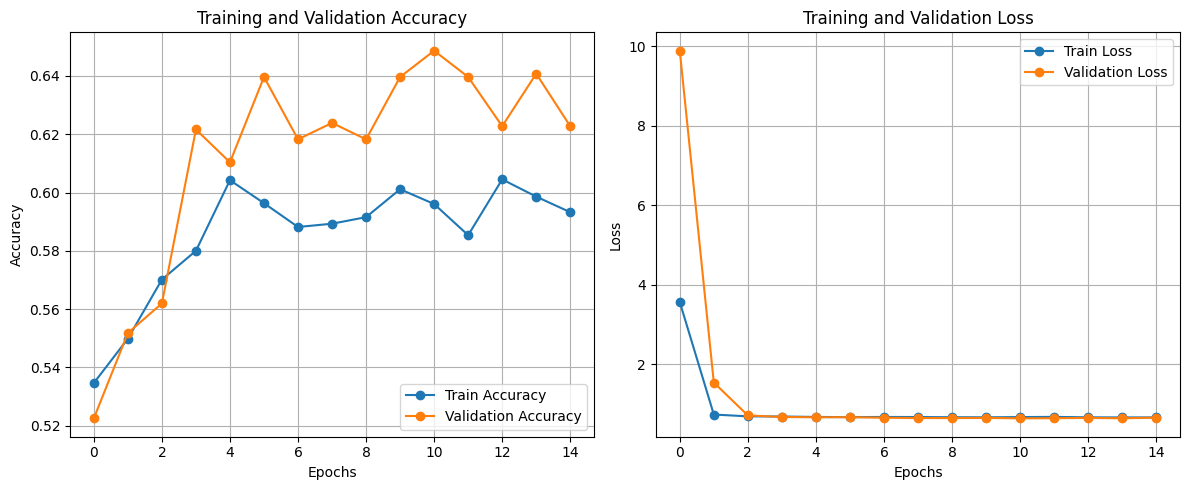

In [14]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#### **Graph of Confusion Matrix**

35/35 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step


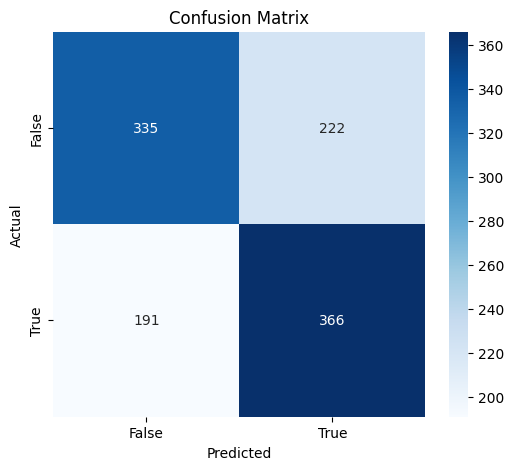


Classification Report:

              precision    recall  f1-score   support

       False       0.64      0.60      0.62       557
        True       0.62      0.66      0.64       557

    accuracy                           0.63      1114
   macro avg       0.63      0.63      0.63      1114
weighted avg       0.63      0.63      0.63      1114



In [15]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))


## 📊 Model Evaluation
After training, the model was evaluated on unseen test data. Key results:

- **✅ Final Test Accuracy: 62.93%**

- **📉 Confusion Matrix showed noticeable class confusion, indicating possible data limitations or noise**

- **📄 Classification Report revealed moderate precision and recall for both classes**

- **📷 Visual validation with random test images highlighted inconsistencies in model predictions**

#### **Print the Test Images after Model Training**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


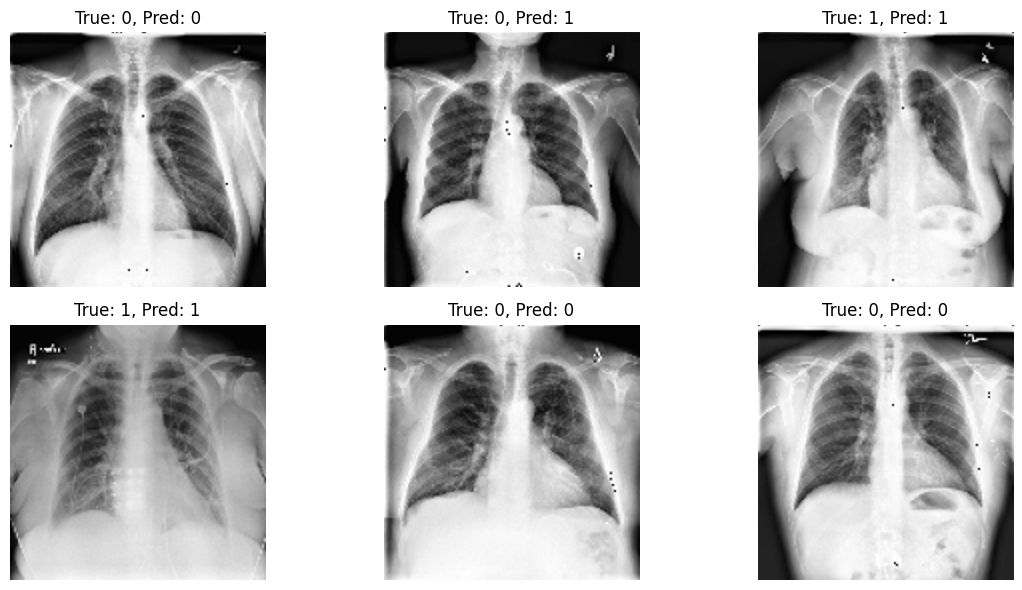

In [16]:
import random

idxs = random.sample(range(len(X_test)), 6)
plt.figure(figsize=(12,6))
for i, idx in enumerate(idxs):
    img = X_test[idx]
    pred_label = np.argmax(model.predict(np.expand_dims(img, axis=0)))
    true_label = y_test[idx]
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 🔍 Observations & Challenges
- The relatively **low accuracy (~63%)** suggests that while the model learned some **distinguishing patterns, the dataset may require further refinement, expansion, or noise reduction**.

- **Potential improvements** could include using **CTR annotation as a supervised signal**, trying **transfer learning (e.g., ResNet, EfficientNet)**, or applying attention mechanisms to improve region focus